In [66]:
import pandas as pd
from sklearn.cluster import k_means
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from math import log

Goal: categorize cities by population

This will allow us to add an easily interpretable demographic attribute to dimensions in order to help analysis.

In [3]:
population = pd.read_csv('../../us-cities-demographics.csv', sep=';')

In [4]:
population.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


## City distribution by population

Population ranges between ~50,000 and ~8,000,000

In [92]:
population['Total Population'].describe()

count    2.891000e+03
mean     1.989668e+05
std      4.475559e+05
min      6.321500e+04
25%      8.042900e+04
50%      1.067820e+05
75%      1.752320e+05
max      8.550405e+06
Name: Total Population, dtype: float64

In [83]:
def city_population(df):
    return (
        df
        .groupby(['City', 'State Code'])
        ['Total Population']
        .max('Total Population')
        .to_frame()
        .reset_index()
        .rename(columns={
            'City': 'city',
            'State Code': 'state',
            'Total Population': 'population'
        })
    )

In [84]:
def population_hist(df):
    plt.figure()
    plt.hist(x=df['population'], log=True, bins=50)
    plt.show()

City sizes clearly follow a power law:

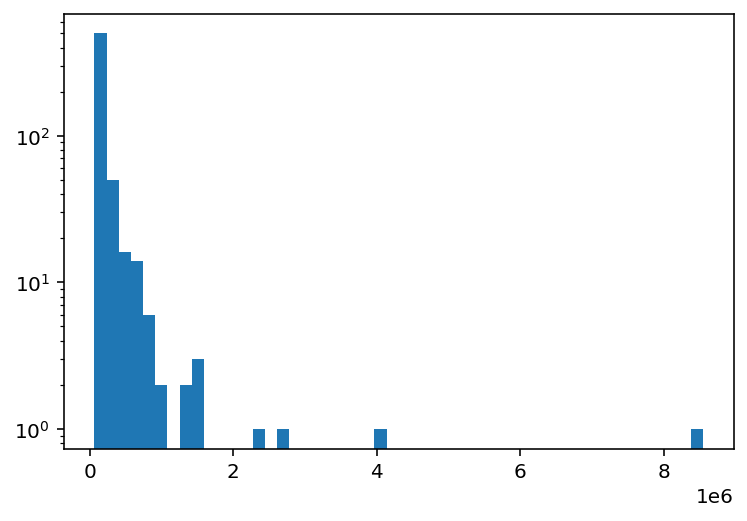

In [85]:
(
    population
    .pipe(city_population)
    .pipe(population_hist)
)

## City categorizaton by population size

From https://data.oecd.org/popregion/urban-population-by-city-size.htm:

> Definition of Urban population by city size

> ... Urban areas in OECD countries are classified as: large metropolitan areas if they have a population of 1.5 million or more; metropolitan areas if their population is between 500 000 and 1.5 million; medium-size urban areas if their population is between 200 000 and 500 000; and, small urban areas if their population is between 50 000 and 200 000.

In [107]:
city_size_desc = [
    [0, 'small (50K - 200K)'],
    [1, 'medium (200K - 500K)'],
    [2, 'large (500K - 1,5M)'],
    [3, 'very large (> 1,5M)'],
]

In [108]:
city_size_desc = pd.DataFrame(city_size_desc, columns=['size', 'size_desc'])

In [110]:
city_size_desc

,size,size_desc
0,0,small (50K - 200K)
1,1,medium (200K - 500K)
2,2,"large (500K - 1,5M)"
3,3,"very large (> 1,5M)"


In [94]:
def classify_city(pop):
    if pop < 200000:
        return 0
    elif pop < 500000:
        return 1
    elif pop < 1500000:
        return 2
    else:
        return 3

In [95]:
def classify_cities(df):
    return df.assign(size=df['population'].apply(classify_city))

In [111]:
def merge_size_desc(df):
    return df.merge(city_size_desc)

In [112]:
city_sizes = (
    population
    .pipe(city_population)
    .pipe(classify_cities)
    .pipe(merge_size_desc)
)

In [113]:
city_sizes.head()

,city,state,population,size,size_desc
0,Abilene,TX,125876,0,small (50K - 200K)
1,Akron,OH,197553,0,small (50K - 200K)
2,Alafaya,FL,85264,0,small (50K - 200K)
3,Alameda,CA,78614,0,small (50K - 200K)
4,Albany,GA,71109,0,small (50K - 200K)


A quick sanity check:

In [114]:
city_sizes.groupby('size').first()

,city,state,population,size_desc
size,,,,
0,Abilene,TX,125876,small (50K - 200K)
1,Anaheim,CA,350738,medium (200K - 500K)
2,Albuquerque,NM,559131,"large (500K - 1,5M)"
3,Chicago,IL,2720556,"very large (> 1,5M)"


In [119]:
def size_counts(df):
    return (
        df
        .groupby(['size', 'size_desc'])
        .count()
        ['city']
        .rename('count')
        .to_frame()
    )

Again, the city size power law is clear, there is an inverse exponential relation between city size and frequency:

In [120]:
(
    city_sizes
    .pipe(size_counts)
)

,,count
size,size_desc,
0,small (50K - 200K),477
1,medium (200K - 500K),85
2,"large (500K - 1,5M)",28
3,"very large (> 1,5M)",6


Can be easily joined with demographics on city and state.

In [101]:
filepath = '../curated/city_size.csv'

In [102]:
city_sizes.to_csv(filepath, index=False)

In [103]:
pd.read_csv(filepath).head()

,city,state,population,size
0,Abilene,TX,125876,0
1,Akron,OH,197553,0
2,Alafaya,FL,85264,0
3,Alameda,CA,78614,0
4,Albany,GA,71109,0
